In [1]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Load dataset
train_data = pd.read_csv('data/balanced_emnist_subset.csv', nrows=1000)
test_data = pd.read_csv('data/balanced_emnist_test_subset.csv', nrows=1000)

In [3]:
# Preprocess train data
x_train = train_data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32') / 255.0
y_train = train_data.iloc[:, 0].values.astype('int')

# Preprocess test data
x_test = test_data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32') / 255.0
y_test = test_data.iloc[:, 0].values.astype('int')

# Resize and normalize data
x_train_resized = torch.tensor(x_train).unsqueeze(1)  # Add channel dimension
x_test_resized = torch.tensor(x_test).unsqueeze(1)
x_train_resized = torch.nn.functional.interpolate(x_train_resized, size=(224, 224), mode='bilinear')
x_test_resized = torch.nn.functional.interpolate(x_test_resized, size=(224, 224), mode='bilinear')

In [4]:
# Convert to RGB
x_train_rgb = x_train_resized.repeat(1, 3, 1, 1)
x_test_rgb = x_test_resized.repeat(1, 3, 1, 1)

# Normalize with mean and std for ImageNet
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

x_train_normalized = (x_train_rgb - mean) / std
x_test_normalized = (x_test_rgb - mean) / std

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Prepare data loaders
train_dataset = TensorDataset(x_train_normalized, y_train_tensor)
test_dataset = TensorDataset(x_test_normalized, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
# Initialize variables to store overall predictions and true labels for LOOCV
all_preds = []
all_true = []

In [6]:
# LOOCV loop (limit to 10 iterations for demonstration)
for i in range(min(10, len(x_train_normalized))):
    print(f"LOOCV Iteration {i + 1}/{min(10, len(x_train_normalized))}")

    # Split data into training and testing
    x_test_cv = x_train_normalized[i:i + 1]
    y_test_cv = y_train_tensor[i:i + 1]
    x_train_cv = torch.cat((x_train_normalized[:i], x_train_normalized[i + 1:]))
    y_train_cv = torch.cat((y_train_tensor[:i], y_train_tensor[i + 1:]))

    # Create DataLoader for training
    train_dataset_cv = TensorDataset(x_train_cv, y_train_cv)
    train_loader_cv = DataLoader(train_dataset_cv, batch_size=16, shuffle=True)

    # Initialize new model for each iteration
    model = models.alexnet(weights='IMAGENET1K_V1')
    model.classifier[6] = nn.Linear(4096, 46)
    model.to(torch.device('cpu'))

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training phase (train for 3 epochs for demonstration)
    model.train()
    for epoch in range(3):
        running_loss = 0.0
        correct_predictions = 0
        for inputs, labels in train_loader_cv:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on the current test data
    model.eval()
    with torch.no_grad():
        outputs = model(x_test_cv)
        pred = outputs.argmax(dim=1)
        all_preds.extend(pred.numpy())
        all_true.extend(y_test_cv.numpy())

# Compute overall metrics
mean_accuracy = accuracy_score(all_true, all_preds)
mean_precision = precision_score(all_true, all_preds, average='weighted', zero_division=0)
mean_f1_score = f1_score(all_true, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_true, all_preds, labels=range(46))

# Print results
print("\n=== LOOCV Results ===")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean F1 Score: {mean_f1_score:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

LOOCV Iteration 1/10


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 57.9MB/s]


LOOCV Iteration 2/10
LOOCV Iteration 3/10
LOOCV Iteration 4/10
LOOCV Iteration 5/10
LOOCV Iteration 6/10
LOOCV Iteration 7/10
LOOCV Iteration 8/10
LOOCV Iteration 9/10
LOOCV Iteration 10/10

=== LOOCV Results ===
Mean Accuracy: 0.9000
Mean Precision: 1.0000
Mean F1 Score: 0.9474
Confusion Matrix:
[[9 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


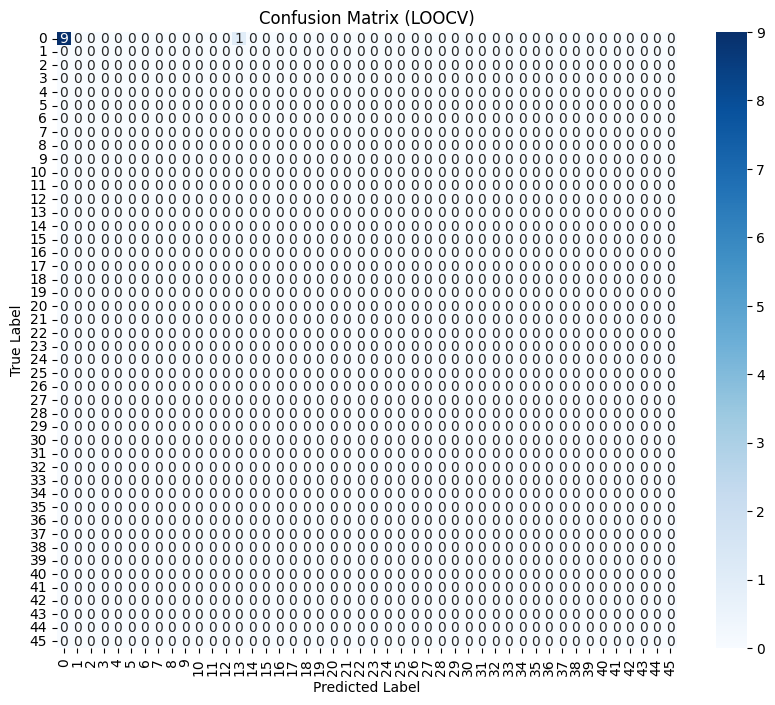

In [7]:
# Plot confusion matrix or further analyze it
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(46), yticklabels=range(46))
plt.title("Confusion Matrix (LOOCV)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()